 # Working with CGM
    

In [ ]:
import pandas as pd

In [ ]:
import LabData
from LabData.DataLoaders.Loader import Loader

In [ ]:
cgmLoader = Loader.get_loader("CGMLoader")

In [ ]:
cgm = cgmLoader.get_data(study_ids=49)

In [ ]:
cgm_df = cgm.df
cgm_meta = cgm.df_metadata

In [ ]:
cgm_df

## Sleep data

It will be useful later when I will have to find define the night for all the people

In [ ]:
sleep_df = pd.read_pickle('/net/mraid08/export/genie/LabData/Data/WIS/sleep_wakeup.dat')

In [ ]:
sleep_df.reset_index('RegistrationCode', inplace=True)

In [ ]:
sleep_df.loc[:, ['RegistrationCode']] = sleep_df.loc[:,'RegistrationCode'].astype(int).astype(str)

In [ ]:
sleep_df

In [ ]:
sleep_df[sleep_df['RegistrationCode'] == '579543']

## CGM Metrics

In [ ]:
cgm_df

In [ ]:
cgm_df.reset_index(inplace=True)

In [ ]:
cgm_df['Day'] = cgm_df['Date'].dt.date
cgm_df

In [ ]:
stats = cgm_df.copy()

In [ ]:
stats

Seems like variation calculation lasts a bit too long. Better ways?

In [ ]:
stats = stats.groupby(['RegistrationCode', 'ConnectionID', 'Day'], as_index=False)['GlucoseValue'].agg(['mean','std'])
stats['CV'] = stats['std'] / stats['mean']

In [ ]:
stats

## Heatmap

In [ ]:
import plotly.graph_objects as go

In [ ]:
stats = stats.reset_index(level='Day' )

In [ ]:
stats

In [ ]:
reg_code = list(set(stats.index.get_level_values('RegistrationCode')))
reg_code.sort()

In [ ]:
len(reg_code)

In [ ]:
stats['Day'].astype(str)

In [ ]:
day = list(set(stats['Day'].astype(str)))
len(day)

In [ ]:
day.sort()
#print(day)

In [ ]:
stats.dtypes

In [ ]:
stats.loc[('203977', slice(None)),:]

In [ ]:
small_stats =  stats.loc[('111527', '1926'):('203977','5897')]
small_stats

In [ ]:
reg_code_list = list(set(small_stats.index.get_level_values('RegistrationCode')))
reg_code_list.sort()


In [ ]:
list_of_cvs = []

for reg_code in reg_code_list:
    list_of_cvs.append(list(small_stats.loc[(reg_code, slice(None)), 'CV']))
# print(list_of_cvs)

In [ ]:
day = list(set(small_stats['Day'].astype(str)))
len(day)

In [ ]:
# reg_code_list

In [ ]:
small_stats = small_stats.reset_index('ConnectionID')

In [ ]:
for reg_code in reg_code_list:
    small_stats.loc[reg_code,'Day_no'] = small_stats.loc[reg_code,'Day'] - small_stats.loc[reg_code,'Day'][0:1]

In [ ]:
small_stats.dtypes

In [ ]:
reg_code_list = ['rc'+i for i in reg_code_list]

In [ ]:
# reg_code_list

In [ ]:
day = list(set(small_stats['Day_no'].astype(str))).sort()

In [ ]:
print(day)

In [ ]:
fig = go.Figure(data=go.Heatmap(
                    z=list_of_cvs,
                    x=day,
                    y=reg_code_list,
                    ))
fig.show()

## Functions

In [ ]:
def filter_by_time(df, start, end):
    
    """
    The function filters the cgm entries between certain hours of the day. 
    The output is a dataframe containing the entries between start and end hour of each day.
    :param df: CGM DataFrame
    :param start: string of a type 'hh:mm'
    :param end: string of a type 'hh:mm'
    :return: filtered DataFrame with an index set to 'RegistrationCode', 'Day' and 'Time'
    """

    df = df.reset_index(['RegistrationCode', 'ConnectionID'])
    filtered_df = df.between_time(start, end)
    pd.options.mode.chained_assignment = None  # to avoid the warning message about chained assignments
#     filtered_df['Time'] = filtered_df.index - filtered_df.index.normalize()
    filtered_df = filtered_df.reset_index()
    filtered_df = filtered_df.set_index(['RegistrationCode', 'ConnectionID', 'Date'])
    filtered_df = filtered_df.sort_index(level=['RegistrationCode','ConnectionID', 'Date'])
    
    return filtered_df

In [ ]:
def count_stats(cgm_df):
    stats = cgm_df.reset_index()
    stats['Day'] = stats['Date'].dt.date
    stats = stats.groupby(['RegistrationCode', 'ConnectionID', 'Day'], as_index=False)['GlucoseValue'].agg(['mean','std'])
    stats['CV'] = stats['std'] / stats['mean']
    return stats
    

In [ ]:
def make_heatmap(stats_df, column_name):
    """    """
    stats_df = stats_df.reset_index(['ConnectionID','Day'])
    reg_code_list = list(set(stats_df.index.get_level_values('RegistrationCode')))
    reg_code_list.sort()
    
    for reg_code in reg_code_list:
        stats_df.loc[reg_code,'Day_no'] = stats_df.loc[reg_code,'Day'] - stats_df.loc[reg_code,'Day'][0:1]
    
    days_list = list(set(stats_df['Day_no'].astype(str))).sort()
    
    list_of_values = []
    for reg_code in reg_code_list:
        list_of_values.append(list(stats_df.loc[reg_code, column_name]))
    
    reg_code_list = ['rc'+i for i in reg_code_list]
    
    fig = go.Figure(data=go.Heatmap(
                    z=list_of_values,
                    x=days_list,
                    y=reg_code_list,
                    ))
    fig.show()
    
    
    

In [ ]:
st = count_stats(cgm_df)

In [ ]:
day_num_df = st.groupby([rc])['mean'].count().rename('num_values')
st = st.join(day_num_df).sort_values(['num_values', 'rc', 'Day'])


In [ ]:
night_df = filter_by_time(cgm_df, '01:00', '07:00')

In [ ]:
night_df

In [ ]:
st = count_stats(night_df)

# Night glucose on a small T2D dataset
 Looking for associations between lifestyle data, nutrition and night glucose levels

First, load the data. If I load it using the study ID then only 4 people are loaded. I need to load the whole CGM data and then filter for the correct connections.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import LabData
from LabData.DataLoaders.Loader import Loader

In [ ]:
cgmLoader = Loader.get_loader("CGMLoader")

In [ ]:
cgm = cgmLoader.get_data()

In [ ]:
cgm_df = cgm.df
cgm_meta = cgm.df_metadata

In [ ]:
# Correct connections of the t2d study with allocation 0 - control, 1 - main
t2d_conns = {9202:{0:[1551, 1552], 1: [1608, 1609]}, 9640:{1:[1607], 0:[1553]}, 9641:{0:[1554], 1:[1605, 1606]},10344:{0:[2134], 1:[2135]}, 9837:{0:[2136], 1:[2137]}, 9838:{0:[2227, 2228], 1:[2229]}, \
                         11756:{0:[3132], 1:[2997]},11563:{0:[3133], 1:[3001, 3002]}, 11631:{0:[3346], 1:[3241]}, 11861:{0:[3444, 3445], 1:[3303]}, 12109:{0:[3446], 1:[3302]},\
                         11624:{0:[3393], 1:[3510]}, 12026:{0:[3395], 1:[3511]}, 12216:{0:[3394], 1:[3509]}, 12282:{0:[3507], 1:[3508]},12299:{0:[4286], 1:[4042]}, 7811:{0:[4287],\
                        1:[4116]}, 12653: {0:[4452], 1:[4229, 4230]}, 11399:{0: [4449], 1:[4448]}, 12843:{0:[4451], 1:[4450]}, 11446:{0:[4194, 4195], 1:[4453]}, 13043:{0:[4718], 1:[4541]},13449:{0:[4950],1:[5102]}}

In [ ]:
CID_list = [1551, 1552, 1608, 1609, 1607, 1553, 1554, 1605, 1606, 2134, 2135, 2136, 2137, 2227, 2228, 2229, 3132, 2997, 3133, 3001, 3002,\
           3346, 3241, 3444, 3445, 3303, 3446, 3302, 3393, 3510, 3395, 3511, 3394, 3509, 3507, 3508, 4286, 4042, 4287, 4116, 4452, 4229, 4230,\
           4449, 4448, 4451, 4450, 4194, 4195, 4453, 4718, 4541, 4950, 5102]

Make strings out of integer CIDs

In [ ]:
CID_list = [str(i) for i in CID_list]

In [ ]:
print(CID_list)

In [ ]:
len(set(CID_list))

In [ ]:
cgm_t2d = cgm_df[cgm_df.index.get_level_values('ConnectionID').isin(CID_list)]

In [ ]:
len(set(cgm_t2d.index.get_level_values('ConnectionID')))

In [ ]:
cgm_t2d.index.get_level_values('RegistrationCode').nunique()

In [ ]:
regcodes_list = ['136529', '256342', '258029', '292372', '292738', '32708', '3375786', '3579890', '429763',
                             '477312', '579543', '583231', '683035', '69789', '717606', '753413', '762879', '794542', 
                             '856766', '85854',  '927011', '928786', '933765']

Now I have a data frame containing CGM for all the T2D study participants.

In [ ]:
cgm_t2d

Remove first days of connections to have better quality data

In [ ]:
%%time
cgm_t2d = cgmLoader._remove_first_day_of_connections(cgm_t2d)
cgm_t2d

## Plotly express lineplot

I want to be able to visualize a single CGM for a specific day and a specific person

In [ ]:
import plotly.express as px

In [ ]:
set(cgm_t2d.loc[('579543', slice(None), slice(None)), :].index.get_level_values('ConnectionID'))

In [ ]:
def plotly_cgm(cgm_df):
    cgm_df = cgm_df.reset_index('Date')
    return px.line(cgm_df, x="Date", y="GlucoseValue", title='CGM')
    

In [ ]:
cgm_t2d.query("RegistrationCode == '579543' and ConnectionID == '2227'")

In [ ]:
fig = plotly_cgm(cgm_df=cgm_t2d.query("RegistrationCode == '579543' and ConnectionID == '2227'"))

In [ ]:
fig.show()

In [ ]:
plotly_cgm(cgm_df=cgm_t2d.query("RegistrationCode == '477312' and ConnectionID == '4718'"))

Another possibility of plotting the CGM with non-interactive matplotlib

In [ ]:
slicedf = cgm_t2d.query("RegistrationCode == '477312' and ConnectionID == '4718'")
# slicedf.set_index(['Date'],inplace=True)
slicedf.loc[:,['GlucoseValue']].plot()
plt.show()

## Food Log

To define the night for a single day for a study participant, I need to either use the sleep data, which is not available for everyone or use the food log looking at the last and first meal time. In this section I want to look at the CGM and the food log chart in parallel. I want to see whether CGM, sleep log and food log go in line with each other or there are some contradictions (for example, sleeping time is earlier than the last logging of the food)

In [ ]:
from LabData.DataLoaders.DietLoggingLoader import DietLoggingLoader

In [ ]:
dll = DietLoggingLoader()

In [ ]:
log = dll.get_data().df

Let's filter the food log for the T2D participants

In [ ]:
regcodes_list = ['136529', '256342', '258029', '292372', '292738', '32708', '3375786', '3579890', '429763',
                             '477312', '579543', '583231', '683035', '69789', '717606', '753413', '762879', '794542', 
                             '856766', '85854',  '927011', '928786', '933765']

In [ ]:
log_t2d = log[log.index.get_level_values('RegistrationCode').isin(regcodes_list)]
log_t2d

Now I want to make sure the dates here are the same as the dates in the cgm data frame

In [ ]:
log_t2d = dll.add_nutrients(log_t2d, ['energy_kcal', 'carbohydrate_g'])

In [ ]:
log_t2d = dll.squeeze_log(log_t2d)

In [ ]:
log_t2d

In [ ]:
cgm_t2d.reset_index(inplace=True)

In [ ]:
cgm_t2d.groupby('RegistrationCode', as_index=False).nth(0)

# Night glucose on the complete data

In [1]:
from LabData.DataLoaders.CGMLoader import CGMLoader
from LabData.DataLoaders.SleepLoader import SleepLoader
from LabUtils.addloglevels import sethandlers
sethandlers()

(None, None)

In [2]:
import datetime
import pandas as pd

In [3]:
cgml = CGMLoader()
sl = SleepLoader()

In [4]:
cgm = cgml.get_data().df

2020-22-01 16:52:25 INFO Loader.py:296 Starting to load data for CGMLoader
2020-22-01 16:52:25 INFO CGMLoader.py:81 Starting to load CGM data
2020-22-01 16:52:25 INFO Caching.py:125 Loading con_metadata from cache...
2020-22-01 16:52:25 INFO Caching.py:125 Loading cgm from cache...
2020-22-01 16:52:27 INFO CGMLoader.py:88 Finished to load CGM data
2020-22-01 16:52:27 INFO Loader.py:298 Finished loading data for CGMLoader
2020-22-01 16:52:27 INFO Loader.py:296 Starting to load data for SubjectLoader
2020-22-01 16:52:27 INFO Caching.py:125 Loading subjects from cache...
2020-22-01 16:52:27 INFO Loader.py:298 Finished loading data for SubjectLoader


In [5]:
sleep = sl.get_data().df

2020-22-01 16:52:34 INFO Loader.py:296 Starting to load data for SleepLoader


/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/pandas/core/indexes/base.py:183: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


2020-22-01 16:52:36 INFO Loader.py:298 Finished loading data for SleepLoader
2020-22-01 16:52:36 INFO Loader.py:296 Starting to load data for SubjectLoader
2020-22-01 16:52:36 INFO Caching.py:125 Loading subjects from cache...
2020-22-01 16:52:36 INFO Loader.py:298 Finished loading data for SubjectLoader


Retain night sleep only

In [6]:
night_cgm = cgml.get_night_cgm(cgm,sleep)

2020-22-01 16:52:48 INFO timeutils.py:16  ***** get_night_cgm ***** Time elapsed: 10.36


In [7]:
night_cgm

GlucoseValue  PPGR  \
RegistrationCode ConnectionID Date                                            
1                1319         2016-02-22 23:15:31+02:00         106.0   0.0   
                              2016-02-22 23:20:31+02:00         106.0   0.0   
                              2016-02-22 23:25:31+02:00         105.0   0.0   
                              2016-02-22 23:30:31+02:00         105.0   0.0   
                              2016-02-22 23:35:31+02:00         104.0   0.0   
...                                                               ...   ...   
999443           2157         2017-12-06 05:52:00+02:00          68.0   NaN   
                              2017-12-06 06:07:00+02:00          65.0   NaN   
                              2017-12-06 06:22:00+02:00          64.0   NaN   
                              2017-12-06 06:37:00+02:00          65.0   NaN   
                              2017-12-06 06:52:00+02:00          64.0   NaN   

                                                                       sleep_time  \
RegistrationCode ConnectionID Date                                                  
1                1319         2016-02-22 23:15:31+02:00 2016-02-22 23:15:00+02:00   
                              2016-02-22 23:20:31+02:00 2016-02-22 23:15:00+02:00   
                              2016-02-22 23:25:31+02:00 2016-02-22 23:15:00+02:00   
                              2016-02-22 23:30:31+02:00 2016-02-22 23:15:00+02:00   
                              2016-02-22 23:35:31+02:00 2016-02-22 23:15:00+02:00   
...                                                                           ...   
999443           2157         2017-12-06 05:52:00+02:00 2017-12-06 00:37:27+02:00   
                              2017-12-06 06:07:00+02:00 2017-12-06 00:37:27+02:00   
                              2017-12-06 06:22:00+02:00 2017-12-06 00:37:27+02:00   
                              2017-12-06 06:37:00+02:00 2017-12-06 00:37:27+02:00   
                              2017-12-06 06:52:00+02:00 2017-12-06 00:37:27+02:00   

                                                                      wakeup_time  
RegistrationCode ConnectionID Date                                                 
1                1319         2016-02-22 23:15:31+02:00 2016-02-23 07:20:00+02:00  
                              2016-02-22 23:20:31+02:00 2016-02-23 07:20:00+02:00  
                              2016-02-22 23:25:31+02:00 2016-02-23 07:20:00+02:00  
                              2016-02-22 23:30:31+02:00 2016-02-23 07:20:00+02:00  
                              2016-02-22 23:35:31+02:00 2016-02-23 07:20:00+02:00  
...                                                                           ...  
999443           2157         2017-12-06 05:52:00+02:00 2017-12-06 07:10:48+02:00  
                              2017-12-06 06:07:00+02:00 2017-12-06 07:10:48+02:00  
                              2017-12-06 06:22:00+02:00 2017-12-06 07:10:48+02:00  
                              2017-12-06 06:37:00+02:00 2017-12-06 07:10:48+02:00  
                              2017-12-06 06:52:00+02:00 2017-12-06 07:10:48+02:00  

[888533 rows x 4 columns]

In [8]:
night_cgm

GlucoseValue  PPGR  \
RegistrationCode ConnectionID Date                                            
1                1319         2016-02-22 23:15:31+02:00         106.0   0.0   
                              2016-02-22 23:20:31+02:00         106.0   0.0   
                              2016-02-22 23:25:31+02:00         105.0   0.0   
                              2016-02-22 23:30:31+02:00         105.0   0.0   
                              2016-02-22 23:35:31+02:00         104.0   0.0   
...                                                               ...   ...   
999443           2157         2017-12-06 05:52:00+02:00          68.0   NaN   
                              2017-12-06 06:07:00+02:00          65.0   NaN   
                              2017-12-06 06:22:00+02:00          64.0   NaN   
                              2017-12-06 06:37:00+02:00          65.0   NaN   
                              2017-12-06 06:52:00+02:00          64.0   NaN   

                                                                       sleep_time  \
RegistrationCode ConnectionID Date                                                  
1                1319         2016-02-22 23:15:31+02:00 2016-02-22 23:15:00+02:00   
                              2016-02-22 23:20:31+02:00 2016-02-22 23:15:00+02:00   
                              2016-02-22 23:25:31+02:00 2016-02-22 23:15:00+02:00   
                              2016-02-22 23:30:31+02:00 2016-02-22 23:15:00+02:00   
                              2016-02-22 23:35:31+02:00 2016-02-22 23:15:00+02:00   
...                                                                           ...   
999443           2157         2017-12-06 05:52:00+02:00 2017-12-06 00:37:27+02:00   
                              2017-12-06 06:07:00+02:00 2017-12-06 00:37:27+02:00   
                              2017-12-06 06:22:00+02:00 2017-12-06 00:37:27+02:00   
                              2017-12-06 06:37:00+02:00 2017-12-06 00:37:27+02:00   
                              2017-12-06 06:52:00+02:00 2017-12-06 00:37:27+02:00   

                                                                      wakeup_time  
RegistrationCode ConnectionID Date                                                 
1                1319         2016-02-22 23:15:31+02:00 2016-02-23 07:20:00+02:00  
                              2016-02-22 23:20:31+02:00 2016-02-23 07:20:00+02:00  
                              2016-02-22 23:25:31+02:00 2016-02-23 07:20:00+02:00  
                              2016-02-22 23:30:31+02:00 2016-02-23 07:20:00+02:00  
                              2016-02-22 23:35:31+02:00 2016-02-23 07:20:00+02:00  
...                                                                           ...  
999443           2157         2017-12-06 05:52:00+02:00 2017-12-06 07:10:48+02:00  
                              2017-12-06 06:07:00+02:00 2017-12-06 07:10:48+02:00  
                              2017-12-06 06:22:00+02:00 2017-12-06 07:10:48+02:00  
                              2017-12-06 06:37:00+02:00 2017-12-06 07:10:48+02:00  
                              2017-12-06 06:52:00+02:00 2017-12-06 07:10:48+02:00  

[888533 rows x 4 columns]

I had 1142889 rows, with new filtering method I have 888533 rows left. Hopefully these are better quality nights

In [9]:
min_df = night_cgm[night_cgm.index.get_level_values('Date').time > datetime.time(16, 0, 0)]

In [10]:
min_df.index.get_level_values('Date').time.min()

datetime.time(21, 6)

In [11]:
night_cgm[night_cgm.index.get_level_values('Date').time == datetime.time(16, 0, 35)]

,,,GlucoseValue,PPGR,sleep_time,wakeup_time
RegistrationCode,ConnectionID,Date,,,,


In [12]:
night_cgm[(night_cgm.index.get_level_values('Date').time > datetime.time(16, 0, 35)) & (night_cgm.index.get_level_values('Date').time < datetime.time(18, 0, 35))]

,,,GlucoseValue,PPGR,sleep_time,wakeup_time
RegistrationCode,ConnectionID,Date,,,,


# Sleep distribution

In [66]:
from LabData.DataLoaders.SleepLoader import SleepLoader
from LabUtils.addloglevels import sethandlers
sethandlers()

AssertionError: 

In [67]:
import datetime
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
import pandas as pd

In [68]:
sl = SleepLoader()

In [69]:
sleep = sl.get_data().df

2020-22-01 19:03:32 INFO Loader.py:296 Starting to load data for SleepLoader


/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/pandas/core/indexes/base.py:183: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


2020-22-01 19:03:33 INFO Loader.py:298 Finished loading data for SleepLoader
2020-22-01 19:03:33 INFO Loader.py:296 Starting to load data for SubjectLoader
2020-22-01 19:03:33 INFO Caching.py:125 Loading subjects from cache...
2020-22-01 19:03:33 INFO Loader.py:298 Finished loading data for SubjectLoader


In [70]:
sleep_filtered = sl.filter_for_night_sleep(sleep)

In [71]:
sleep_filtered

,sleep_time,wakeup_time,Duration
RegistrationCode,,,
0,2015-06-15 00:09:00+03:00,2015-06-15 07:52:42+03:00,07:43:42
0,2015-06-15 23:15:00+03:00,2015-06-16 06:50:48+03:00,07:35:48
0,2015-06-17 00:30:00+03:00,2015-06-17 07:30:21+03:00,07:00:21
0,2015-06-17 23:20:00+03:00,2015-06-18 07:15:56+03:00,07:55:56
0,2015-06-19 01:09:36+03:00,2015-06-19 08:33:51+03:00,07:24:15
...,...,...,...
2147483647,2015-05-19 23:00:00+03:00,2015-05-20 07:15:53+03:00,08:15:53
2147483647,2015-05-21 00:23:58+03:00,2015-05-21 07:15:33+03:00,06:51:35
2147483647,2015-05-22 00:02:20+03:00,2015-05-22 06:45:26+03:00,06:43:06


In [72]:
sleep_filtered.index.nunique()

2008

In [73]:
sleep_filtered['Duration'] = (sleep_filtered.wakeup_time - sleep_filtered.sleep_time) / pd.Timedelta(hours=1)

In [74]:
sleep_filtered.describe()

,Duration
count,34043.000000
mean,7.021826
std,0.939550
min,5.000278
25%,6.322222
50%,7.011667
75%,7.744306
max,8.999167


In [75]:
7.122+1.33

8.452

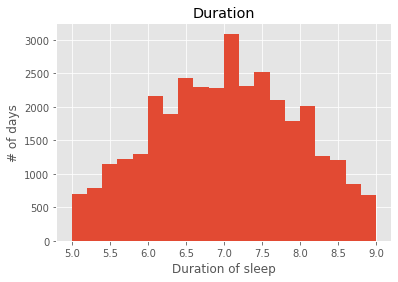

In [76]:
sleep_filtered.hist(bins=20)
plt.xlabel('Duration of sleep')
plt.ylabel('# of days');

From this graph we see that most people sleep 5,5 to 9,5 hours, I can include it into filtering function

In [77]:
sleep_filtered['sleep_time_plot'] = (sleep_filtered['sleep_time'] - sleep_filtered['sleep_time'].dt.normalize()) / pd.Timedelta(hours=1)

In [78]:
sleep_filtered['wakeup_time_plot'] = (sleep_filtered['wakeup_time'] - sleep_filtered['wakeup_time'].dt.normalize()) / pd.Timedelta(hours=1)

In [79]:
sleep_filtered

,sleep_time,wakeup_time,Duration,sleep_time_plot,wakeup_time_plot
RegistrationCode,,,,,
0,2015-06-15 00:09:00+03:00,2015-06-15 07:52:42+03:00,7.728333,0.150000,7.878333
0,2015-06-15 23:15:00+03:00,2015-06-16 06:50:48+03:00,7.596667,23.250000,6.846667
0,2015-06-17 00:30:00+03:00,2015-06-17 07:30:21+03:00,7.005833,0.500000,7.505833
0,2015-06-17 23:20:00+03:00,2015-06-18 07:15:56+03:00,7.932222,23.333333,7.265556
0,2015-06-19 01:09:36+03:00,2015-06-19 08:33:51+03:00,7.404167,1.160000,8.564167
...,...,...,...,...,...
2147483647,2015-05-19 23:00:00+03:00,2015-05-20 07:15:53+03:00,8.264722,23.000000,7.264722
2147483647,2015-05-21 00:23:58+03:00,2015-05-21 07:15:33+03:00,6.859722,0.399444,7.259167
2147483647,2015-05-22 00:02:20+03:00,2015-05-22 06:45:26+03:00,6.718333,0.038889,6.757222


In [80]:
mask = sleep_filtered['sleep_time_plot'] >= 21

In [81]:
sleep_filtered.loc[mask, 'sleep_time_plot'] = sleep_filtered[mask]['sleep_time_plot'] - 24

2020-22-01 19:05:56 INFO utils.py:129 Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-22-01 19:05:56 INFO utils.py:141 NumExpr defaulting to 8 threads.


In [82]:
sleep_filtered = sleep_filtered.reset_index()

In [83]:
means = sleep_filtered.groupby('RegistrationCode')[('sleep_time_plot','wakeup_time_plot')].mean()
means

,sleep_time_plot,wakeup_time_plot
RegistrationCode,,
0,-0.133038,7.240367
1,0.076120,6.814745
100863,2.050000,9.694444
10260,-0.960000,6.566667
102813,-0.573810,6.145238
...,...,...
995638,-0.290648,6.836759
997427,-1.430865,5.589391
997735,-0.097418,7.107933


In [84]:
means = means.sort_values('sleep_time_plot').reset_index()

In [85]:
means['RegistrationCode'] = 'rc' + means['RegistrationCode']

In [86]:
means

,RegistrationCode,sleep_time_plot,wakeup_time_plot
0,rc543407,-2.950000,4.966667
1,rc360798,-2.735000,6.257778
2,rc521937,-2.624722,6.326389
3,rc415308,-2.620278,5.207500
4,rc451482,-2.453056,6.340833
...,...,...,...
2003,rc644341,2.666667,8.416667
2004,rc395212,2.677778,9.000000
2005,rc373796,2.737083,8.924167
2006,rc191596,2.750000,9.250000


In [89]:
import plotly.express as px
# fig = px.scatter(means, x='RegistrationCode', y='time', color='type', marginal_y='density')
fig = px.scatter(means, x='RegistrationCode', y='sleep_time_plot')
fig.show()


Most of the people go to sleep from 22 to 2

In [152]:
fig = go.Figure(data=go.Scatter(x=means['RegistrationCode'], y=means['wakeup_time_plot'], mode='markers'))

fig.show()

In [28]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=means['RegistrationCode'], y=means['wakeup_time_plot'], mode='markers', name='wake up time'))
fig.add_trace(go.Scatter(x=means['RegistrationCode'], y=means['sleep_time_plot'], mode='markers', name='sleep time'))

fig.show()

#fig = px.scatter(means, x='RegistrationCode', y='time', color='type', marginal_y='density')

# MAGE of the night

In [14]:
night_cgm

GlucoseValue  PPGR  \
RegistrationCode ConnectionID Date                                            
1                1319         2016-02-22 23:15:31+02:00         106.0   0.0   
                              2016-02-22 23:20:31+02:00         106.0   0.0   
                              2016-02-22 23:25:31+02:00         105.0   0.0   
                              2016-02-22 23:30:31+02:00         105.0   0.0   
                              2016-02-22 23:35:31+02:00         104.0   0.0   
...                                                               ...   ...   
999443           2157         2017-12-06 05:52:00+02:00          68.0   NaN   
                              2017-12-06 06:07:00+02:00          65.0   NaN   
                              2017-12-06 06:22:00+02:00          64.0   NaN   
                              2017-12-06 06:37:00+02:00          65.0   NaN   
                              2017-12-06 06:52:00+02:00          64.0   NaN   

                                                                       sleep_time  \
RegistrationCode ConnectionID Date                                                  
1                1319         2016-02-22 23:15:31+02:00 2016-02-22 23:15:00+02:00   
                              2016-02-22 23:20:31+02:00 2016-02-22 23:15:00+02:00   
                              2016-02-22 23:25:31+02:00 2016-02-22 23:15:00+02:00   
                              2016-02-22 23:30:31+02:00 2016-02-22 23:15:00+02:00   
                              2016-02-22 23:35:31+02:00 2016-02-22 23:15:00+02:00   
...                                                                           ...   
999443           2157         2017-12-06 05:52:00+02:00 2017-12-06 00:37:27+02:00   
                              2017-12-06 06:07:00+02:00 2017-12-06 00:37:27+02:00   
                              2017-12-06 06:22:00+02:00 2017-12-06 00:37:27+02:00   
                              2017-12-06 06:37:00+02:00 2017-12-06 00:37:27+02:00   
                              2017-12-06 06:52:00+02:00 2017-12-06 00:37:27+02:00   

                                                                      wakeup_time  
RegistrationCode ConnectionID Date                                                 
1                1319         2016-02-22 23:15:31+02:00 2016-02-23 07:20:00+02:00  
                              2016-02-22 23:20:31+02:00 2016-02-23 07:20:00+02:00  
                              2016-02-22 23:25:31+02:00 2016-02-23 07:20:00+02:00  
                              2016-02-22 23:30:31+02:00 2016-02-23 07:20:00+02:00  
                              2016-02-22 23:35:31+02:00 2016-02-23 07:20:00+02:00  
...                                                                           ...  
999443           2157         2017-12-06 05:52:00+02:00 2017-12-06 07:10:48+02:00  
                              2017-12-06 06:07:00+02:00 2017-12-06 07:10:48+02:00  
                              2017-12-06 06:22:00+02:00 2017-12-06 07:10:48+02:00  
                              2017-12-06 06:37:00+02:00 2017-12-06 07:10:48+02:00  
                              2017-12-06 06:52:00+02:00 2017-12-06 07:10:48+02:00  

[888533 rows x 4 columns]

In [21]:
night_cgm_slice = night_cgm.loc[('579543', slice(None), slice(None)), 'GlucoseValue': 'PPGR']

In [22]:
night_cgm_slice

GlucoseValue    PPGR
RegistrationCode ConnectionID Date                                           
579543           2227         2017-11-21 22:26:00+02:00         206.0     NaN
                              2017-11-21 22:42:00+02:00         223.0   0.000
                              2017-11-21 22:57:00+02:00         211.0   0.000
                              2017-11-21 23:12:00+02:00         178.0  10.125
                              2017-11-21 23:27:00+02:00         175.0  20.375
...                                                               ...     ...
                 3306         2018-07-19 04:47:00+03:00         105.0  10.625
                              2018-07-19 05:02:00+03:00         104.0  17.250
                              2018-07-19 05:17:00+03:00         102.0  26.750
                              2018-07-19 05:32:00+03:00         103.0  30.625
                              2018-07-19 05:47:00+03:00         109.0  23.125

[3166 rows x 2 columns]

In [23]:
night_mage = cgml.calculate_mage(night_cgm_slice)

2020-22-01 17:09:15 INFO CGMLoader.py:474 Start calculating mage...
2020-22-01 17:09:15 INFO CGMLoader.py:478 date_level computed
2020-22-01 17:09:15 INFO CGMLoader.py:480 str_date_level computed
2020-22-01 17:09:15 INFO CGMLoader.py:483 split performed
2020-22-01 17:09:18 INFO timeutils.py:16  ***** r_mage ***** Time elapsed: 3.50


In [24]:
night_mage

,RegistrationCode,date,mage,hmage,lmage,ge
0,579543,2017-11-21,16.50,33.00,0.0,1.0
7,579543,2017-11-22,60.00,0.00,120.0,1.0
31,579543,2017-11-23,30.50,0.00,61.0,1.0
60,579543,2017-11-24,13.50,0.00,27.0,1.0
88,579543,2017-11-25,12.00,12.00,12.0,4.0
...,...,...,...,...,...,...
3045,579543,2018-07-14,0.00,0.00,0.0,0.0
3076,579543,2018-07-15,6.00,7.00,5.0,2.0
3097,579543,2018-07-16,10.75,14.00,7.5,3.0
3121,579543,2018-07-17,4.17,4.33,4.0,4.0


In [26]:
tmp = night_cgm_slice[night_cgm_slice['Day'] == '2017/11/22']
tmp

GlucoseValue    PPGR  \
RegistrationCode ConnectionID Date                                              
579543           2227         2017-11-22 00:12:00+02:00         172.0  34.250   
                              2017-11-22 00:27:00+02:00         188.0   0.750   
                              2017-11-22 00:42:00+02:00         199.0   0.000   
                              2017-11-22 00:57:00+02:00         199.0   0.000   
                              2017-11-22 01:12:00+02:00         195.0   0.000   
                              2017-11-22 01:27:00+02:00         192.0   0.000   
                              2017-11-22 01:42:00+02:00         189.0   0.000   
                              2017-11-22 01:57:00+02:00         179.0   0.000   
                              2017-11-22 02:12:00+02:00         172.0   0.000   
                              2017-11-22 02:27:00+02:00         176.0   0.000   
                              2017-11-22 02:42:00+02:00         175.0   0.000   
                              2017-11-22 02:57:00+02:00         167.0     NaN   
                              2017-11-22 03:12:00+02:00         155.0     NaN   
                              2017-11-22 03:27:00+02:00         142.0     NaN   
                              2017-11-22 03:42:00+02:00         144.0     NaN   
                              2017-11-22 03:57:00+02:00         160.0     NaN   
                              2017-11-22 04:12:00+02:00         173.0     NaN   
                              2017-11-22 04:27:00+02:00         170.0     NaN   
                              2017-11-22 04:42:00+02:00         165.0     NaN   
                              2017-11-22 04:58:00+02:00         167.0  24.625   
                              2017-11-22 23:13:00+02:00         287.0     NaN   
                              2017-11-22 23:28:00+02:00         296.0     NaN   
                              2017-11-22 23:44:00+02:00         293.0   0.000   
                              2017-11-22 23:59:00+02:00         265.0   0.000   

                                                                Day      Time  
RegistrationCode ConnectionID Date                                             
579543           2227         2017-11-22 00:12:00+02:00  2017/11/22  00:12:00  
                              2017-11-22 00:27:00+02:00  2017/11/22  00:27:00  
                              2017-11-22 00:42:00+02:00  2017/11/22  00:42:00  
                              2017-11-22 00:57:00+02:00  2017/11/22  00:57:00  
                              2017-11-22 01:12:00+02:00  2017/11/22  01:12:00  
                              2017-11-22 01:27:00+02:00  2017/11/22  01:27:00  
                              2017-11-22 01:42:00+02:00  2017/11/22  01:42:00  
                              2017-11-22 01:57:00+02:00  2017/11/22  01:57:00  
                              2017-11-22 02:12:00+02:00  2017/11/22  02:12:00  
                              2017-11-22 02:27:00+02:00  2017/11/22  02:27:00  
                              2017-11-22 02:42:00+02:00  2017/11/22  02:42:00  
                              2017-11-22 02:57:00+02:00  2017/11/22  02:57:00  
                              2017-11-22 03:12:00+02:00  2017/11/22  03:12:00  
                              2017-11-22 03:27:00+02:00  2017/11/22  03:27:00  
                              2017-11-22 03:42:00+02:00  2017/11/22  03:42:00  
                              2017-11-22 03:57:00+02:00  2017/11/22  03:57:00  
                              2017-11-22 04:12:00+02:00  2017/11/22  04:12:00  
                              2017-11-22 04:27:00+02:00  2017/11/22  04:27:00  
                              2017-11-22 04:42:00+02:00  2017/11/22  04:42:00  
                              2017-11-22 04:58:00+02:00  2017/11/22  04:58:00  
                              2017-11-22 23:13:00+02:00  2017/11/22  23:13:00  
                              2017-11-22 23:28:00+02:00  2017/11/22  23:28:00  
                              

In [45]:
tmp = night_cgm_slice.reset_index('Date').drop(columns=['Day', 'Time'])

In [46]:
tmp['Date'] += datetime.timedelta(hours=3)

In [49]:
tmp = tmp.set_index('Date', append=True)

In [50]:
tmp_mage = cgml.calculate_mage(tmp)

2020-22-01 17:23:39 INFO CGMLoader.py:474 Start calculating mage...
2020-22-01 17:23:39 INFO CGMLoader.py:478 date_level computed
2020-22-01 17:23:39 INFO CGMLoader.py:480 str_date_level computed
2020-22-01 17:23:39 INFO CGMLoader.py:483 split performed
2020-22-01 17:23:43 INFO timeutils.py:16  ***** r_mage ***** Time elapsed: 4.07


In [51]:
tmp_mage

,RegistrationCode,date,mage,hmage,lmage,ge
0,579543,2017-11-22,16.5,33.0,0.0,1.0
27,579543,2017-11-23,0.0,0.0,0.0,0.0
58,579543,2017-11-24,0.0,0.0,0.0,0.0
84,579543,2017-11-25,0.0,0.0,0.0,0.0
114,579543,2017-11-26,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
3043,579543,2018-07-14,0.0,0.0,0.0,0.0
3075,579543,2018-07-15,6.0,7.0,5.0,2.0
3097,579543,2018-07-16,4.0,0.0,8.0,1.0
3118,579543,2018-07-17,2.5,5.0,0.0,1.0


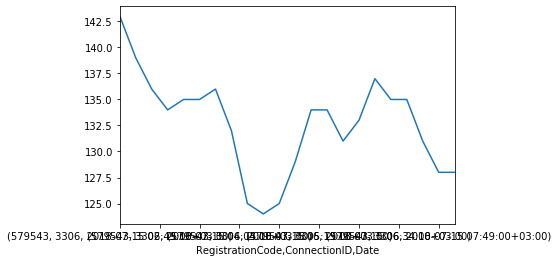

In [64]:
tmp[tmp.Day == '2018/07/15']["GlucoseValue"].plot()

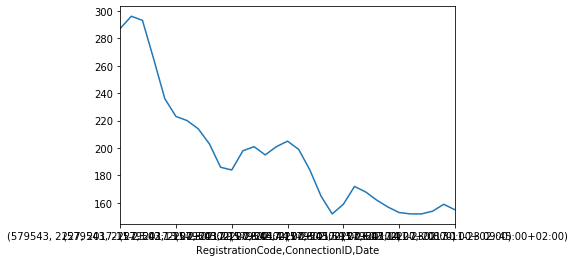

In [63]:
tmp[tmp.Day == '2017/11/23']["GlucoseValue"].plot()

In [52]:
night_mage

,RegistrationCode,date,mage,hmage,lmage,ge
0,579543,2017-11-21,16.50,33.00,0.0,1.0
7,579543,2017-11-22,60.00,0.00,120.0,1.0
31,579543,2017-11-23,30.50,0.00,61.0,1.0
60,579543,2017-11-24,13.50,0.00,27.0,1.0
88,579543,2017-11-25,12.00,12.00,12.0,4.0
...,...,...,...,...,...,...
3045,579543,2018-07-14,0.00,0.00,0.0,0.0
3076,579543,2018-07-15,6.00,7.00,5.0,2.0
3097,579543,2018-07-16,10.75,14.00,7.5,3.0
3121,579543,2018-07-17,4.17,4.33,4.0,4.0
